In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
from scripts.core import *

In [3]:
from scripts.learners import ModelLearner, ParallelLearner
from scripts.dataset import CSVData, MovingObjectData, SingleCSV
from scripts.loss import weightedMSE
import pickle

As loading and cleaning the dataset takes some time, we load the dataset and save it in a pickle file to be loaded below. This makes the process of loading the dataset quicker the next time we run the model.

In [45]:
data=MovingObjectData.fromCSVFolder("/home/sufiyan/data/Daimler/100_vids/csv/")
with open("/home/sufiyan/data/Daimler/100_vids/pickled_160_csv_14Feb", 'wb') as f:
    pickle.dump(data, f)

/home/sufiyan/MTP/code/Notebooks/scripts/dataset.py:209: DtypeWarning: Columns (2376,2504) have mixed types. Specify dtype option on import or set low_memory=False.
  if preload: self.data = [SingleCSV.fromCSV(self.files[i], **self.kwargs).data for i in range(self.__len__())]


In [ ]:
data=MovingObjectData.fromCSVFolder("/home/sufiyan/data/Daimler/100_vids/csv/")
with open("/home/sufiyan/data/Daimler/100_vids/pickled_MovingObject_160_csv_19Feb", 'wb') as f:
    pickle.dump(data, f)

Loading the dataset. To see how the dataset works, see [scripts/dataset.py](https://github.com/dumbPy/MTP/blob/master/scripts/dataset.py)

In [4]:
with open("/home/sufiyan/data/Daimler/100_vids/pickled_160_csv_14Feb", 'rb') as f:
    dataset=pickle.load(f)

In [4]:
with open("/home/sufiyan/data/Daimler/100_vids/pickled_MovingObject_160_csv_19Feb", 'rb') as f:
    dataset=pickle.load(f)

Reason for Braking:  Driving/Moving Object


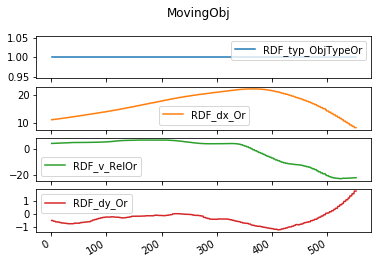

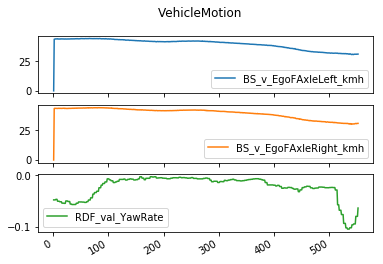

In [5]:
dataset.plot(0)

In [6]:
path="/home/sufiyan/Common_data/mtp2/dataset/NEW/100_vids/"

Total number of files in the dataset

In [7]:
len(dataset)

161

Number of files for **Left**, **Right** and **Other** classes respectively. These include flipped files for Left and Right

In [8]:
print(len([1 for x,y in dataset if y==0]))
print(len([1 for x,y in dataset if y==1]))
print(len([1 for x,y in dataset if y==2]))

61
61
39


Seperating train and test files.

In [9]:
np.random.seed(10) #seting seed for always selecting same train and test set
totalFiles=len(dataset)
testFiles=np.random.choice(totalFiles, int(0.2*totalFiles)) #20% files as test files

Defining the Dataloaders for training and validation data

In [10]:
trainLoader=torch.utils.data.DataLoader([(x,y) for i,(x,y) in enumerate(dataset) if not i in testFiles])
testLoader=torch.utils.data.DataLoader([(x,y) for i,(x,y) in enumerate(dataset) if i in testFiles])

A simple model defined below is trained. It consists of a 2 Layer LSTM followed by a fully connected Layer

In [12]:
class CSVmodel(nn.Module):
    def __init__(self,categories=3, input_size=7, hidden_size=10, dropout=0.1):
        super().__init__()
        self.l1=nn.LSTM(input_size=input_size,hidden_size=hidden_size, dropout=dropout, num_layers=2)
        self.l2=nn.Linear(in_features=hidden_size,out_features=categories)
        self.softmax=nn.Softmax()
    def forward(self,x):
        x,_=self.l1(x)
        x=x[:,-1,:]
        x= self.l2(x)
        return x

ParallelLearner class takes ModelLearners that take models and other parameters like learning rate, optimization function and loss function.

In [13]:
learner=ParallelLearner([
                ModelLearner(CSVmodel(), lr=0.001, loss_fn=torch.nn.MSELoss, 
                             optim=torch.optim.SGD, modelName='movingObjectDataModel' ),
                ModelLearner(CSVmodel(), lr=0.001, loss_fn=torch.nn.CrossEntropyLoss, 
                             optim=torch.optim.SGD, modelName='movingObjectDataModel' ),
                ModelLearner(CSVmodel(), lr=0.001, loss_fn=partial(weightedMSE, [2,2,1]), 
                              optim=torch.optim.SGD, modelName='movingObjectDataModel' ),
                ModelLearner(CSVmodel(), lr=0.001, loss_fn=partial(weightedMSE, [1,1,2]), 
                             optim=torch.optim.SGD, modelName='movingObjectDataModel' ),
                ],
        epochs=10, trainLoader=trainLoader, validLoader=testLoader)

The ParallelLearner trains all the models parallelly by using the same data

In [14]:
learner.train(200)

Plotting the loss for all the 4 models above. 

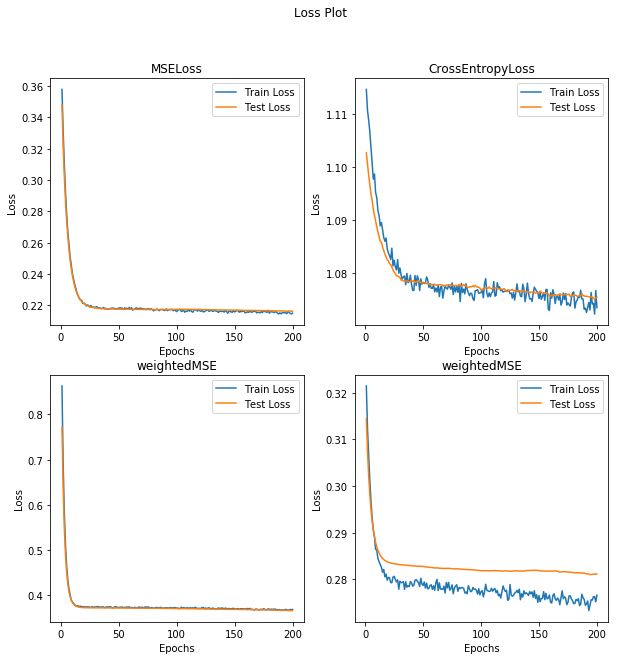

In [15]:
learner.plotLoss(figsize=(10,10))

Plotting confusion matrix for training dataset for all the four loss functions namely weighted_MSE (1,1,0.1), weighted_MSE(0.5, 0.5, 0.1), MSE and CrossEntropyLoss.

In [18]:
print("MSE"); print(learner.learners[0].train_confusion_matrix_list[-1])
print("CE"); print(learner.learners[1].train_confusion_matrix_list[-1])
print("wMSE_2:1:1"); print(learner.learners[2].train_confusion_matrix_list[-1])
print("wMSE_1:1:2"); print(learner.learners[3].train_confusion_matrix_list[-1])

MSE
[[37 14  0]
 [28 21  0]
 [28  4  0]]
CE
[[49  2  0]
 [44  5  0]
 [28  4  0]]
wMSE_2:1:1
[[34 17  0]
 [36 13  0]
 [23  9  0]]
wMSE_1:1:2
[[25 26  0]
 [30 19  0]
 [23  9  0]]


Confision Matrix for all the loss functions for test data

In [17]:
print("wMSE1"); print(learner.learners[0].valid_confusion_matrix_list[-1])
print("wMSE2"); print(learner.learners[1].valid_confusion_matrix_list[-1])
print("MSE"); print(learner.learners[2].valid_confusion_matrix_list[-1])
print("CE"); print(learner.learners[3].valid_confusion_matrix_list[-1])

wMSE1
[[3 7 0]
 [6 6 0]
 [4 3 0]]
wMSE2
[[ 9  1  0]
 [12  0  0]
 [ 5  2  0]]
MSE
[[3 7 0]
 [4 8 0]
 [5 2 0]]
CE
[[3 7 0]
 [6 6 0]
 [4 3 0]]


Reason for Braking:  Driving/Moving Object


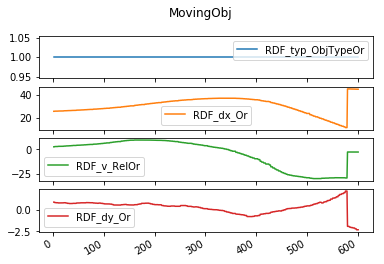

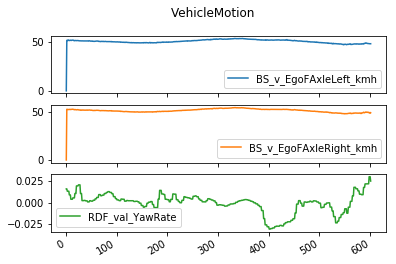

In [6]:
dataset.plot(4)

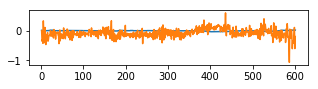

In [12]:
data4=dataset.getSingleCSV(4, all_columns=False)
data4.df.iloc[:,-1].plot(figsize=(5,1))
data4.df["diff"]=data4.df["BS_v_EgoFAxleLeft_kmh"]-data4.df["BS_v_EgoFAxleRight_kmh"]
data4.df["diff"].plot()

In [13]:
df=read_csv_auto(dataset.files[0])

In [15]:
True in ["Angle" in col for col in df.columns]

True

In [16]:
[col for col in df.columns if "Angle" in col]

['GVC_ang_FirstNdAngle',
 'GVC_ang_FirstNdAngle_Status',
 'GVC_ang_SecNdAngle',
 'GVC_ang_SecNdAngle_Status',
 'SRRR_qty_TrlrKinkAngle',
 'SRRR_qty_TrlrKinkAngle_Status',
 'SRRR_ang_TrlrKinkAngle',
 'SRRR_ang_TrlrKinkAngle_Status',
 'SRRL_qty_TrlrKinkAngle',
 'SRRL_qty_TrlrKinkAngle_Status',
 'SRRL_ang_TrlrKinkAngle',
 'SRRL_ang_TrlrKinkAngle_Status',
 'MPC_val_YawAngleLt',
 'MPC_val_YawAngleLt_Status',
 'MPC_val_YawAngleLtMC',
 'MPC_val_YawAngleLtMC_Status',
 'MPC_val_YawAngleRt',
 'MPC_val_YawAngleRt_Status',
 'MPC_val_YawAngleRtMC',
 'MPC_val_YawAngleRtMC_Status',
 'ATC_ang_KinkAngle',
 'ATC_ang_KinkAngle_Status',
 'EED_ang_KinkAngleAlpha',
 'EED_ang_KinkAngleAlpha_Status',
 'EED_ang_KinkAngleBeta',
 'EED_ang_KinkAngleBeta_Status',
 'BSM_ang_KinkAngleGamma',
 'BSM_ang_KinkAngleGamma_Status',
 'BSM_ang_KinkAngleGamma_2CCAN',
 'BSM_ang_KinkAngleGamma_2CCAN_Status',
 'BSM_ang_KinkAngleBeta',
 'BSM_ang_KinkAngleBeta_Status',
 'BSM_C_ert_ATCKinkAngle',
 'BSM_C_erb_ATCKinkAngle',
 'BSM_C_

In [22]:
[col for col in df.columns if ("Wheel" in col and "Angle" in col)]

['BSM_ang_WheelAngle']

In [25]:
[col for col in df.columns if "Angle" in col and "Yaw" in col]

['MPC_val_YawAngleLt',
 'MPC_val_YawAngleLt_Status',
 'MPC_val_YawAngleLtMC',
 'MPC_val_YawAngleLtMC_Status',
 'MPC_val_YawAngleRt',
 'MPC_val_YawAngleRt_Status',
 'MPC_val_YawAngleRtMC',
 'MPC_val_YawAngleRtMC_Status',
 'GPP_C_erb_YawAngleLt',
 'GPP_C_erb_YawAngleRt']

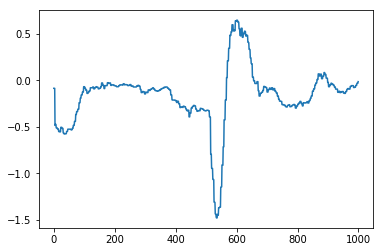

In [17]:
df["BSM_ang_WheelAngle"].plot()

In [ ]:
learner_2=ParallelLearner(
                [ModelLearner(CSVmodel(), lr=0.001, loss_fn=partial(weightedMSE, [1,1,2]), 
                              optim=torch.optim.SGD, modelName='movingObjectDataModel' ),
                 ModelLearner(CSVmodel(), lr=0.001, loss_fn=partial(weightedMSE, [1,1,5]), 
                              optim=torch.optim.SGD, modelName='movingObjectDataModel' ),
                 ModelLearner(CSVmodel(), lr=0.001, loss_fn=partial(weightedMSE, [1,1,10]), 
                              optim=torch.optim.SGD, modelName='movingObjectDataModel' )
                ],epochs=100, trainLoader=trainLoader, printEvery=102, validLoader=testLoader)

In [ ]:
learner_2.train(100)

In [ ]:
learner_2.plotLoss("Loss_for_wMSE_1:1:2",  ["trainLoss_1", "trainLoss_2", "trainLoss_3"], 
                                           ["testLoss_1", "testLoss_2", "testLoss_3"])

In [ ]:
print("wMSE_1:1:2"); print(learner_2.learners[0].valid_confusion_matrix_list[-1])
print("wMSE_1:1:5"); print(learner_2.learners[1].valid_confusion_matrix_list[-1])
print("wMSE_1:1:10"); print(learner_2.learners[2].valid_confusion_matrix_list[-1])

We see that, as we increase the weight for **Other (2)** class to 10, the model does tries to learn the class, but messes the other 2 classes. Other  than that, the model is not able to learn the **Other** class.

The above models were trained only with considering 4 columns representing MovingObjects as below

In [61]:
mov_data=MovingObjectData.fromCSVFolder("/home/sufiyan/data/Daimler/100_vids/csv/", preload=False)

/home/sufiyan/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:1: DtypeWarning: Columns (2376,2504) have mixed types. Specify dtype option on import or set low_memory=False.
  """Entry point for launching an IPython kernel.


Reason for Braking:  Pedestrian A


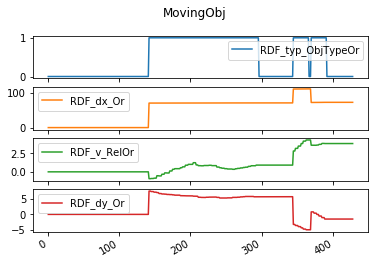

In [62]:
mov_data.plot(1)

As we see here, in the above plot, the model was trained on moving object data where as the ABA had reacted to a Pedestrian's presence and the moving object data is highly non-conclusive as to where the moving object is moving, if at all there is a moving object. Hence we will now try to train the model considering all 12 columns (4 corrosponding to ABA's reaction, Moving Object, Stationary object and Pedestrian each)

In [11]:
full_data=CSVData.fromCSVFolder("/home/sufiyan/data/Daimler/100_vids/csv/")
with open("/home/sufiyan/data/Daimler/100_vids/pickled_CSVData_160_csv_18Feb", 'wb') as f:
    pickle.dump(full_data, f)

/home/sufiyan/MTP/code/Notebooks/scripts/dataset.py:209: DtypeWarning: Columns (2376,2504) have mixed types. Specify dtype option on import or set low_memory=False.
  if preload: self.data = [SingleCSV.fromCSV(self.files[i], **self.kwargs).data for i in range(self.__len__())]


In [44]:
with open("/home/sufiyan/data/Daimler/100_vids/pickled_CSVData_160_csv_18Feb", 'rb') as f:
    full_data=pickle.load(f)

/home/sufiyan/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:1: DtypeWarning: Columns (2376,2504) have mixed types. Specify dtype option on import or set low_memory=False.
  """Entry point for launching an IPython kernel.


Reason for Braking:  Pedestrian A


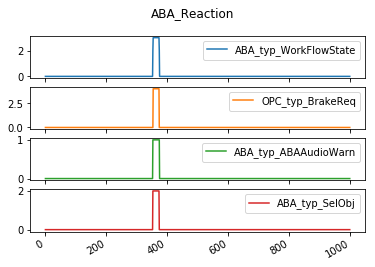

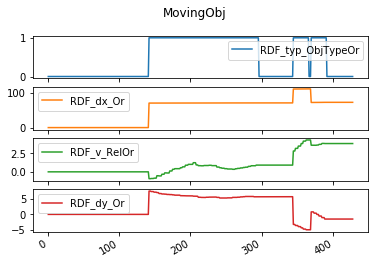

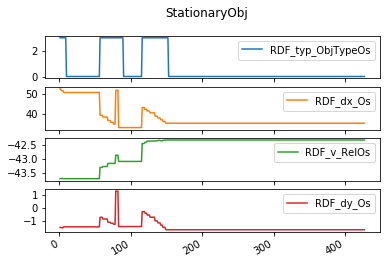

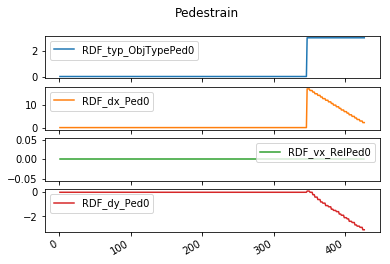

In [16]:
full_data.plot(1)

When we use the full data i.e., [scripts/dataset.CSVData](https://github.com/dumbPy/MTP/blob/3d9ca8ab8b395ae1592e49f38cc503bb5fafedf4/scripts/dataset.py#L203), we see that for the same file, we get all the columns and we hope the simple model defined above might be able to detect **Other (2)** class better.

Let's try to train the model with full  data and see how the model reacts to it

In [ ]:
trainLoader=torch.utils.data.DataLoader([(x,y) for i,(x,y) in enumerate(full_data) if not i in testFiles])
testLoader=torch.utils.data.DataLoader([(x,y) for i,(x,y) in enumerate(full_data) if i in testFiles])

In [ ]:
learner_3=ParallelLearner([
                ModelLearner(CSVmodel(input_size=16, hidden_size=20), 
                             lr=0.001, loss_fn=torch.nn.MSELoss, 
                             optim=torch.optim.SGD, modelName='CSVModel_full_data_1' ),
                ModelLearner(CSVmodel(input_size=16, hidden_size=20), 
                             lr=0.001, loss_fn=torch.nn.CrossEntropyLoss, 
                             optim=torch.optim.SGD, modelName='CSVModel_full_data_2' ),
                ModelLearner(CSVmodel(input_size=16, hidden_size=20), 
                              lr=0.001, loss_fn=partial(weightedMSE, [1,1,2]), 
                              optim=torch.optim.SGD, modelName='CSVModel_full_data_3' ),
                ModelLearner(CSVmodel(input_size=16, hidden_size=20), 
                             lr=0.001, loss_fn=partial(weightedMSE, [1,1,5]), 
                             optim=torch.optim.SGD, modelName='CSVModel_full_data_4' )],
        epochs=100, trainLoader=trainLoader, validLoader=testLoader)

In [ ]:
learner_3.train(epochs=300)

In [ ]:
learner_3.plotLoss(figsize=(10,10))

Plotting Confusion Matrix on train data

In [ ]:
print("MSE"); print(learner_3.learners[0].train_confusion_matrix_list[-1])
print("CE"); print(learner_3.learners[1].train_confusion_matrix_list[-1])
print("wMSE_1:1:2"); print(learner_3.learners[2].train_confusion_matrix_list[-1])
print("wMSE_1:1:5"); print(learner_3.learners[3].train_confusion_matrix_list[-1])

Plotting Confusion Matrix on validation/test data

In [ ]:
print("MSE"); print(learner_3.learners[0].valid_confusion_matrix_list[-1])
print("CE"); print(learner_3.learners[1].valid_confusion_matrix_list[-1])
print("wMSE_1:1:2"); print(learner_3.learners[2].valid_confusion_matrix_list[-1])
print("wMSE_1:1:5"); print(learner_3.learners[3].valid_confusion_matrix_list[-1])

As model with **weighted MSE loss \[1,1,2 \]** seems  to be performing better than rest, we will try training that model further and see how it performs.

We remove all other models from ParallelLearner and train the **weightedMSE** model further

In [ ]:
allModelLearners=learner_3.learners[:]
learner_3.learners=[learner_3.learners[3]]

Training for 100 more epochs (total epochs=400)

In [ ]:
learner_3.train(100)
learner_3.plotLoss(figsize=(10,5))

In [ ]:
print("wMSE_1:1:2  Train \n"); print(learner_3.learners[0].train_confusion_matrix_list[-1])
print("wMSE_1:1:2  Validation \n"); print(learner_3.learners[0].valid_confusion_matrix_list[-1])

Training for 100 more epochs (total epochs=500)

In [ ]:
learner_3.train(100)
learner_3.plotLoss(figsize=(10,5))
print("wMSE_1:1:2  Train \n"); print(learner_3.learners[0].train_confusion_matrix_list[-1])
print("wMSE_1:1:2  Validation \n"); print(learner_3.learners[0].valid_confusion_matrix_list[-1])

Training for 100 more epochs (total epochs=800)

In [ ]:
learner_3.train(300)
learner_3.plotLoss(figsize=(10,5))
print("wMSE_1:1:2  Train \n"); print(learner_3.learners[0].train_confusion_matrix_list[-1])
print("wMSE_1:1:2  Validation \n"); print(learner_3.learners[0].valid_confusion_matrix_list[-1])

The model seems to overfit after a certain epochs. The accuracy over Class 0 improved on train data but not on test data

In [26]:
df=read_csv_auto(full_data.files[1])

/home/sufiyan/anaconda3/envs/fastai/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2903: DtypeWarning: Columns (2376,2504) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f7358008b00>,
      dtype=object)

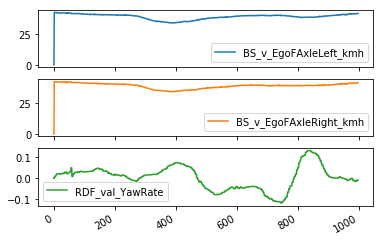

In [28]:
df[["BS_v_EgoFAxleLeft_kmh", "BS_v_EgoFAxleRight_kmh", "RDF_val_YawRate"]].plot(subplots=True)

In [47]:
full_data[0]

(array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]), 0)

In [48]:
full_data[0][0].shape

(552, 16)